In [1]:
# Importing proper Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from dmba import classificationSummary
from dmba.metric import AIC_score
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
# Load dataset
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Drop columns that are identifiers or not useful
df_hr = df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber'])

# Viewing Data
df_hr

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,3,Male,...,3,3,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,4,Male,...,3,1,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,...,4,2,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,4,Male,...,3,4,0,17,3,2,9,6,0,8


In [3]:
# Clean column names
df_hr.columns = [c.replace(' ', '_') for c in df_hr.columns]

# convert target to 0/1
df_hr['Attrition'] = df_hr['Attrition'].map({'Yes':1, 'No':0})

# Treat categorical variables: Convert 'Education' to categorical with labels
edu_map = {1:'BelowCollege', 2:'College', 3:'Bachelor', 4:'Master', 5:'Doctor'}
df_hr['Education'] = df_hr['Education'].map(edu_map)

# Convert categorical variables to dummies (one-hot encoding)
df_hr = pd.get_dummies(df_hr, prefix_sep='_', drop_first=True)

In [4]:
# Partition data
X = df_hr.drop(columns=['Attrition'])
y = df_hr['Attrition']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [5]:
# Fit logistic regression (no regularization effect by setting large C)
logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear', max_iter=1000)
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1e+42, max_iter=1000, solver='liblinear')

In [6]:
# Coefficients
print('intercept:', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
# AIC score (approximate using dmba)
print("AIC:", AIC_score(valid_y, logit_reg.predict(valid_X), df=len(train_X.columns)+1))

intercept: 0.1184951765483863
            Age  DailyRate  DistanceFromHome  EnvironmentSatisfaction  \
coeff -0.005536  -0.000255          0.034852                -0.342861   

       HourlyRate  JobInvolvement  JobLevel  JobSatisfaction  MonthlyIncome  \
coeff     0.00735       -0.267321  0.021935        -0.175773      -0.000086   

       MonthlyRate  ...  JobRole_Laboratory Technician  JobRole_Manager  \
coeff     0.000022  ...                       0.312951         0.005731   

       JobRole_Manufacturing Director  JobRole_Research Director  \
coeff                       -0.138271                  -0.028075   

       JobRole_Research Scientist  JobRole_Sales Executive  \
coeff                   -0.164895                -0.006941   

       JobRole_Sales Representative  MaritalStatus_Married  \
coeff                      0.264581              -0.106661   

       MaritalStatus_Single  OverTime_Yes  
coeff                0.4328      1.064068  

[1 rows x 47 columns]
AIC: 636.312479

In [7]:
# Predictions
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)

logit_result = pd.DataFrame({
    'actual': valid_y,
    'p(0)': [p[0] for p in logit_reg_proba],
    'p(1)': [p[1] for p in logit_reg_proba],
    'predicted': logit_reg_pred
})
print(logit_result.head())

      actual      p(0)      p(1)  predicted
1291       1  0.936925  0.063075          0
1153       1  0.420982  0.579018          1
720        1  0.463699  0.536301          1
763        0  0.656253  0.343747          0
976        0  0.929199  0.070801          0


In [8]:
# Confusion matrices
classificationSummary(train_y, logit_reg.predict(train_X))  # training
classificationSummary(valid_y, logit_reg.predict(valid_X))  # validation

Confusion Matrix (Accuracy 0.8866)

       Prediction
Actual   0   1
     0 745   2
     1  98  37
Confusion Matrix (Accuracy 0.8537)

       Prediction
Actual   0   1
     0 478   8
     1  78  24


Precision: 0.75
Recall: 0.23529411764705882
Specificity: 0.9835390946502057


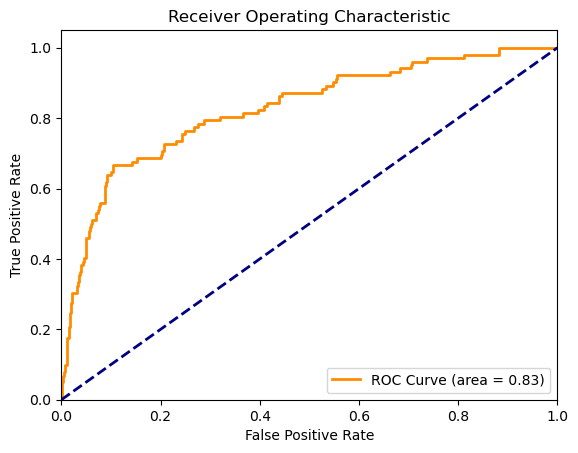

AUC: 0.8272008391834099


In [9]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, auc, roc_auc_score

# Precision, Recall, and Specificity
precision = precision_score(valid_y, logit_reg_pred)
recall = recall_score(valid_y, logit_reg_pred)

tn, fp, fn, tp = confusion_matrix(valid_y, logit_reg_pred).ravel()
specificity = tn / (tn + fp)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Specificity: {specificity}')

# Plot ROC Curve and calculate AUC
fpr, tpr, _ = roc_curve(valid_y, logit_reg_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc}')

# Cluster Model

In [10]:
# Import Proper Libraries
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from pandas.plotting import parallel_coordinates
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster

In [11]:
# Select relevant features for clustering (numeric, meaningful for segmentation)
cluster_df = df[['MonthlyIncome', 'JobSatisfaction', 'EnvironmentSatisfaction',
                 'WorkLifeBalance', 'DistanceFromHome']].copy()

# Set row names to EmployeeNumber
cluster_df.set_index(df['EmployeeNumber'], inplace=True)

# Convert integer data to float
cluster_df = cluster_df.apply(lambda x: x.astype('float64'))

# View Cluster Data
cluster_df

,MonthlyIncome,JobSatisfaction,EnvironmentSatisfaction,WorkLifeBalance,DistanceFromHome
EmployeeNumber,,,,,
1,5993.0,4.0,2.0,1.0,1.0
2,5130.0,2.0,3.0,3.0,8.0
4,2090.0,3.0,4.0,3.0,2.0
5,2909.0,3.0,4.0,3.0,3.0
7,3468.0,2.0,1.0,3.0,2.0
...,...,...,...,...,...
2061,2571.0,4.0,3.0,3.0,23.0
2062,9991.0,1.0,4.0,3.0,6.0
2064,6142.0,2.0,2.0,3.0,4.0


In [12]:
# Compute Euclidean distance
d = pairwise.pairwise_distances(cluster_df, metric='euclidean')
pd.DataFrame(d, columns=cluster_df.index, index=cluster_df.index)

EmployeeNumber,1,2,4,5,7,8,10,11,12,13,...,2054,2055,2056,2057,2060,2061,2062,2064,2065,2068
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,0.000000,863.033603,3903.001281,3084.002108,2525.001980,2925.001026,3323.002257,3300.081514,3533.069770,756.448941,...,2208.168019,4861.076733,6038.043889,3943.003677,3027.004129,3422.071449,3998.005253,149.057036,603.008292,1589.018565
2,863.033603,0.000000,3040.006250,2221.006078,1662.012034,2062.010184,2460.005488,2437.052933,4396.025819,108.683025,...,1345.150921,5724.035115,6901.018983,4806.001144,2164.002542,2559.044744,4861.000617,1012.008399,260.073067,726.002066
4,3903.001281,3040.006250,0.000000,819.000611,1378.003628,978.001022,580.006034,603.401193,7436.029653,3147.099617,...,1695.201758,8764.038795,9941.024645,7846.001083,876.005137,481.460279,7901.001266,4052.001111,3300.000303,2314.008859
5,3084.002108,2221.006078,819.000611,0.000000,559.009839,159.009434,239.012552,217.018432,6617.030225,2328.124138,...,876.361227,7945.039585,9122.024501,7027.000854,57.035077,338.594152,7082.000918,3233.000928,2481.000605,1495.010033
7,2525.001980,1662.012034,1378.003628,559.009839,0.000000,400.017500,798.004386,775.318644,6058.037223,1769.178340,...,318.086466,7386.046439,8563.028611,6468.000850,502.018924,897.250244,6523.001993,2674.000935,1922.002601,936.020833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,3422.071449,2559.044744,481.460279,338.594152,897.250244,497.445474,101.049493,122.012294,6955.000144,2666.003376,...,1214.016062,8283.002113,9460.000159,7365.022675,395.412443,0.000000,7420.020148,3571.051246,2819.079282,1833.062192
2062,3998.005253,4861.000617,7901.001266,7082.000918,6523.001993,6923.001878,7321.000751,7298.022472,465.314947,4754.047013,...,6206.039317,863.280372,2040.082841,55.045436,7025.000356,7420.020148,0.000000,3849.001169,4601.001956,5587.001163
2064,149.057036,1012.008399,4052.001111,3233.000928,2674.000935,3074.002115,3472.000576,3449.058712,3384.054078,905.293875,...,2357.124095,4712.061651,5889.034386,3794.000264,3176.000945,3571.051246,3849.001169,0.000000,752.005984,1738.005178


In [13]:
# Normalizing the data using Z-score standardization
cluster_df_norm = (cluster_df - cluster_df.mean())/cluster_df.std()

# Compute normalized distances
d_norm = pairwise.pairwise_distances(cluster_df_norm, metric='euclidean')
pd.DataFrame(d_norm, columns=cluster_df.index, index=cluster_df.index)

EmployeeNumber,1,2,4,5,7,8,10,11,12,13,...,2054,2055,2056,2057,2060,2061,2062,2064,2065,2068
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,5.960464e-08,3.594323,3.589810,3.560086,3.527441,2.398447,3.286220,4.552440,4.484621,3.738228,...,4.696775,5.560585,3.420168,4.044609,3.583446,4.091942,4.456823,3.382452,2.944775e+00,4.440027
2,3.594323e+00,0.000000,1.619828,1.504019,2.005031,2.620850,1.865256,2.412946,2.440193,2.884298,...,3.980119,3.037045,3.488999,1.684682,1.416808,2.647213,1.669150,1.061413,1.841557e+00,1.920021
4,3.589810e+00,1.619828,0.000000,0.213256,2.905222,1.693787,2.481865,2.716770,3.033947,3.577316,...,4.660314,4.127942,4.242231,3.090437,0.414202,2.894775,2.519648,2.229700,1.821285e+00,2.478040
5,3.560086e+00,1.504019,0.213256,0.000000,2.895507,1.685858,2.476254,2.590804,2.839317,3.442283,...,4.565909,3.955565,4.078953,2.987501,0.247001,2.783988,2.385056,2.157946,1.765980e+00,2.415070
7,3.527441e+00,2.005031,2.905222,2.895507,0.000000,3.582178,2.493485,3.968146,4.089077,3.978011,...,5.163269,4.593664,4.099007,1.919249,2.915983,3.658273,3.243113,1.104716,3.114915e+00,2.061551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,4.091942e+00,2.647213,2.894775,2.783988,3.658273,3.092219,3.935734,1.294223,1.959975,1.841163,...,4.086294,3.422333,2.625505,3.951429,2.568283,0.000000,3.888178,3.192790,3.632898e+00,2.690323
2062,4.456823e+00,1.669150,2.519648,2.385056,3.243113,3.436428,2.322836,3.259079,2.774141,3.722778,...,4.137193,2.719933,4.227136,1.833879,2.351699,3.888178,0.000000,2.213414,2.006064e+00,3.179502
2064,3.382452e+00,1.061413,2.229700,2.157946,1.104716,3.021137,2.054698,3.285262,3.190532,3.427652,...,4.604256,3.733089,3.597678,1.219356,2.154124,3.192790,2.213414,0.000000,2.331890e+00,1.790389


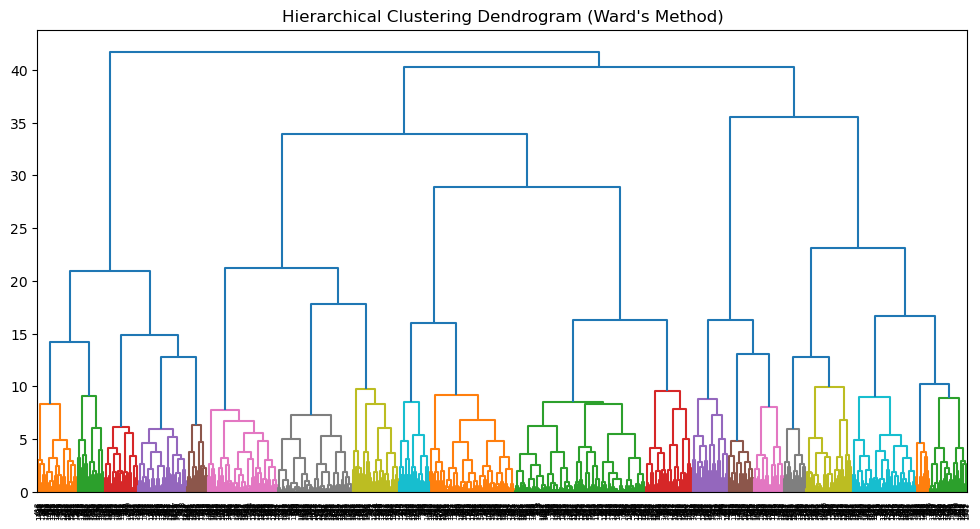

In [14]:
# Hierarchical clustering and dendrogram
Z = linkage(cluster_df_norm, method='ward')  # 'ward' minimizes within-cluster variance
plt.figure(figsize=(12,6))
dendrogram(Z, labels=None, color_threshold=10)
plt.title("Hierarchical Clustering Dendrogram (Ward's Method)")
plt.show()

In [15]:
# Computing cluster membership by "cutting" the dendrogram
memb = fcluster(linkage(cluster_df_norm, method='ward'), 3, criterion='maxclust')
memb = pd.Series(memb, index=cluster_df_norm.index)

# Print cluster membership
for key, item in memb.groupby(memb):
    print(f"Cluster {key}: {len(item)} employees")

Cluster 1: 269 employees
Cluster 2: 766 employees
Cluster 3: 435 employees


In [16]:
# Add membership back to the DataFrame
cluster_df['Cluster'] = memb

# Review cluster characteristics
print(cluster_df.groupby('Cluster').mean())

         MonthlyIncome  JobSatisfaction  EnvironmentSatisfaction  \
Cluster                                                            
1          6322.256506         3.182156                 2.639405   
2          5444.845953         2.622715                 2.697128   
3          8477.862069         2.634483                 2.816092   

         WorkLifeBalance  DistanceFromHome  
Cluster                                     
1               2.687732         21.899628  
2               3.181462          6.531332  
3               2.066667          6.020690  


In [17]:
# Evaluation of Ward's Method CLuster Analysis

# Cut dendrogram into 3 clusters (you can test 2–6 to see what works best)
ward_labels = fcluster(Z, 4, criterion='maxclust')

# Compute Silhouette Score
silhouette_avg_ward = silhouette_score(cluster_df_norm, ward_labels)
print("Silhouette Score for Ward’s Method:", silhouette_avg_ward)

Silhouette Score for Ward’s Method: 0.1690621322953575


In [18]:
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=1, n_init=10)
kmeans_labels = kmeans.fit_predict(cluster_df_norm)

cluster_df['KMeansCluster'] = kmeans_labels

# Compare average profiles of KMeans clusters
print(cluster_df.groupby('KMeansCluster').mean())

               MonthlyIncome  JobSatisfaction  EnvironmentSatisfaction  \
KMeansCluster                                                            
0                4703.618351         3.525266                 2.716755   
1               15521.340249         2.734440                 2.688797   
2                4783.113208         1.469602                 2.746331   

               WorkLifeBalance  DistanceFromHome   Cluster  
KMeansCluster                                               
0                     2.744681          9.401596  1.965426  
1                     2.809129          8.651452  2.390041  
2                     2.763103          9.136268  2.205451  


In [19]:
# Scoring for K-Means Cluster Analysis

silhouette_avg = silhouette_score(cluster_df_norm, kmeans_labels)
print("Silhouette Score for KMeans:", silhouette_avg)

Silhouette Score for KMeans: 0.19105431393434574


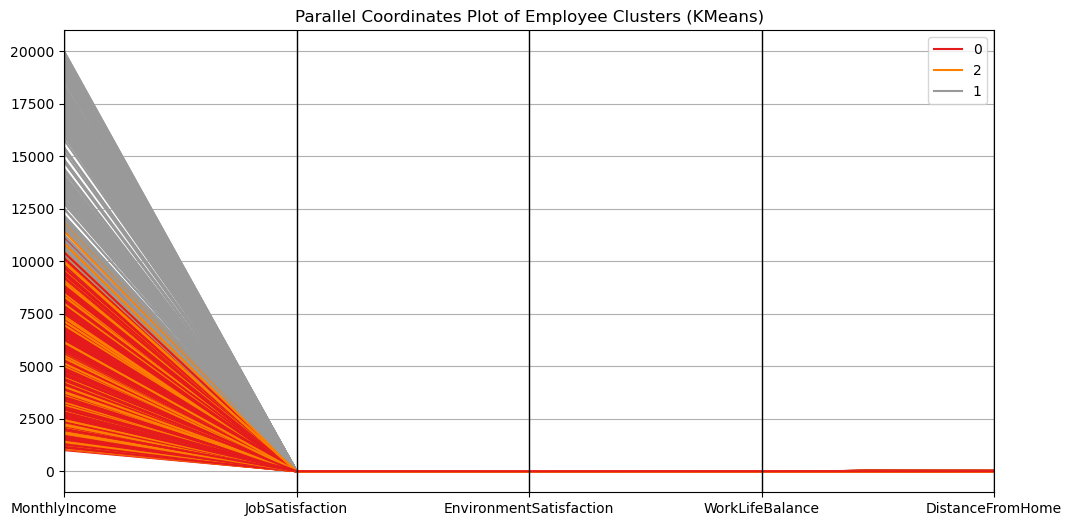

In [20]:
# Parallel coordinates plot for visualization
plt.figure(figsize=(12,6))
parallel_coordinates(cluster_df[['MonthlyIncome','JobSatisfaction',
                                'EnvironmentSatisfaction','WorkLifeBalance',
                                'DistanceFromHome','KMeansCluster']],
                     'KMeansCluster', colormap=plt.cm.Set1)
plt.title("Parallel Coordinates Plot of Employee Clusters (KMeans)")
plt.show()

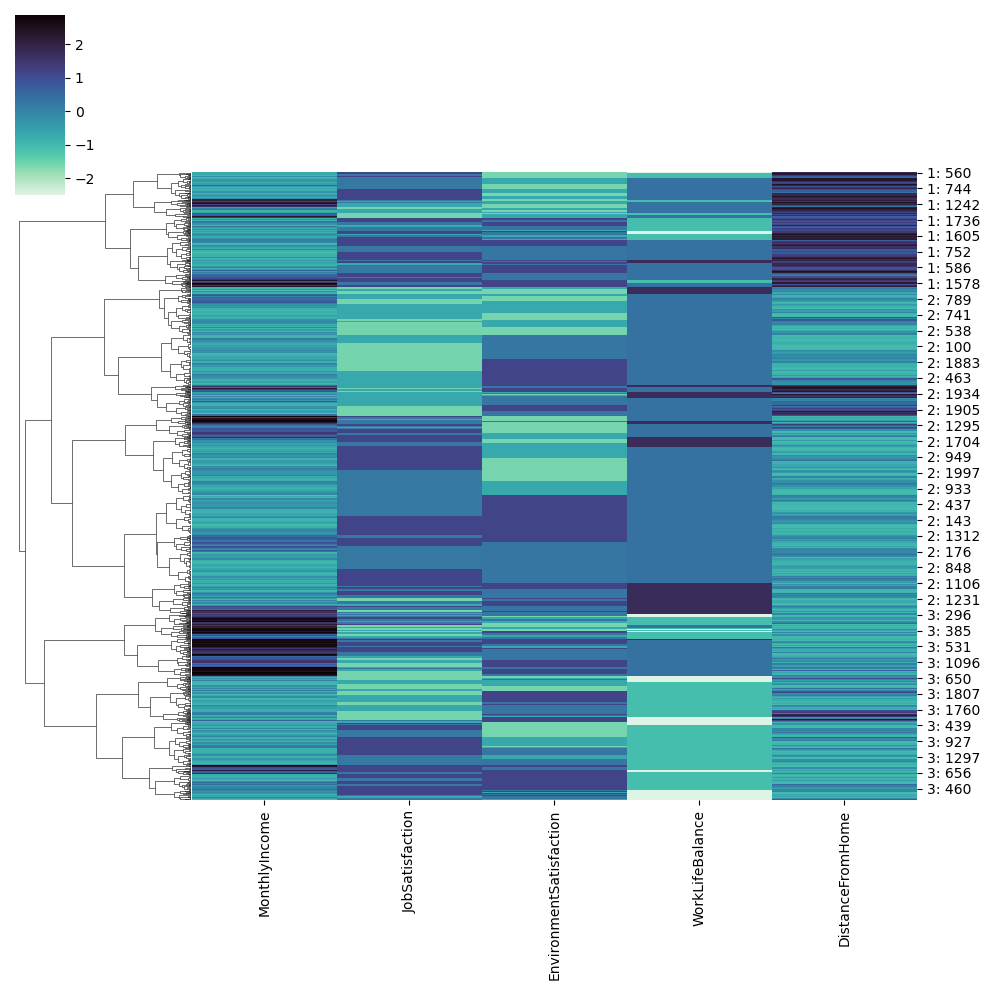

In [21]:
# Creating a Heatmap

# set labels as cluster membership and utility name
cluster_df_norm.index = ['{}: {}'.format(cluster, state)
                          for cluster, state in zip(memb, cluster_df_norm.index)]

# plot heatmap
# the '_r' suffix reverses the color mapping to large = dark
sns.clustermap(cluster_df_norm, method='ward', col_cluster=False, cmap='mako_r')